In [1]:
from scipy.stats import entropy
import pandas
import numpy
from tqdm import tqdm
import sys
import seaborn
import matplotlib
pandas.set_option('display.max_columns', None)
from tqdm.notebook import trange, tqdm
from time import sleep
import numpy
from joblib import Parallel, delayed
seaborn.set_palette("Paired")
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import subprocess
import os.path

In [3]:
OUTPUT_IMAGE_PATH = "./../report/fragments/04_experimental_execution/images/"

In [14]:
def instanciate_runner(executable_path, input_path="./", output_path="/tmp"):

    if os.path.exists(executable_path):
        def execute_experiment( input_file:str, input_size:int, extractions:int, output_file:str = None, generate_dataframe=False, enable_reuse=0,
                                log_pivot_time = 0, log_iteration_time = 0, log_extraction_time = 0, log_swaps = 0, use_random_pivot = 0,
                                use_bfprt = 0, use_iiqs = 0, set_bfprt_alpha = 0.3, set_bfprt_beta = 0.7, set_random_seed = 42, 
                                set_pivot_bias = 0.5, set_redundant_bias = 0.5, thread_id="" ):
            if output_file == None:
                output_file = input_file.split("/")[-1]
            arguments = [
            ('--log-iteration-time=' + str(log_iteration_time)),
            ('--log-pivot-time=' + str(log_iteration_time)),
            ('--log-swaps=' + str(log_iteration_time)),
            ('--log-extraction-time=' + str(log_extraction_time)),
            ('--enable-reuse=' + str(enable_reuse)),
            ('--use-bfprt=' + str(use_bfprt)),
            ('--use-iiqs=' + str(use_iiqs)),
            ('--set-bfprt-alpha=' + str(np.round(set_bfprt_alpha,6))),
            ('--set-bfprt-beta=' + str(np.round(set_bfprt_beta,6))),
            ('--use-random-pivot=' + str(use_random_pivot)),
            ('--set-random-seed=' + str(set_random_seed)),
            ('--set-pivot-bias=' + str(np.round(set_pivot_bias,6))),
            ('--set-redundant-bias=' + str(np.round(set_redundant_bias, 6))),
            ('--input-file=' + '/'.join([input_path, str(input_file)])),
            ('--output-file=' + '/'.join([output_path, str(output_file + thread_id)])),
            ('--input-size=' + str(input_size)),
            ('--extractions=' + str(extractions))]
            # print(" ".join([''+executable_path] + arguments))
            result = subprocess.run(" ".join([''+executable_path] + arguments), shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            # print(result.stdout.decode('utf-8'))
            # print(result.stderr.decode('utf-8'))
            result_df = pandas.read_csv('/'.join([output_path, str(output_file + thread_id)]))
            
            result_deletion = subprocess.run(
                ("rm " + '/'.join([output_path, str(output_file + thread_id)]))
                , shell=True,  stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            
            return result_df
        return execute_experiment
    else:
        return None

In [15]:
#runner = instanciate_runner('/home/kuky_nekoi/magicode/program/base_benchmark/main')
runner = instanciate_runner('/home/kuky_nekoi/Documents/Sources/KuKy_NeKoi/magicode/program/base_benchmark/main_prototype',
                            input_path='/home/kuky_nekoi/Documents/Sources/KuKy_NeKoi/magicode/experiments/01_base_benchmark_data')

In [16]:
def plot_base_benchmark(dataframe, output_file, size=(16, 24), prepend="", hue="param.use_iiqs" ):
    fig, axes = matplotlib.pyplot.subplots(nrows=3, ncols=2, figsize=size)
    
    hue_order = result_df_alphabeta_rand_d[hue].unique()
    hue_order.sort()
    
    seaborn.lineplot(x="snapshot.current_extraction", y="snapshot.total_extraction_time", 
                    data=dataframe, ax=axes[0,0], hue=hue, hue_order=hue_order).set_title(prepend + "Cumulated extraction time")
    seaborn.scatterplot(x="snapshot.current_extraction", y="snapshot.extraction_time", 
                    data=dataframe, linewidth=0, alpha=0.5, ax=axes[1,0], hue=hue, hue_order=hue_order).set_title(prepend + "Extraction time distribution")
    seaborn.scatterplot(x="snapshot.current_extraction", y="snapshot.current_stack_size", 
                    data=dataframe, linewidth=0, alpha=0.5, ax=axes[2,0], hue=hue, hue_order=hue_order).set_title(prepend + "Stack size per extraction")

    plot_df_head = dataframe[ (dataframe["snapshot.current_extraction"] < 1000)]
    
    #fix for logplot
    #plot_df_head["snapshot.extraction_time"] = plot_df_head["snapshot.extraction_time"].apply(lambda x: x+0.1)
    #plot_df_head["snapshot.current_stack_size"] = plot_df_head["snapshot.current_stack_size"].apply(lambda x: x+0.1)
    #display(plot_df_head["snapshot.current_stack_size"].describe())
    
    axes[0,1].set(yscale="symlog")
    axes[1,1].set(yscale="symlog")
    axes[2,1].set(yscale="symlog")

    seaborn.lineplot(x="snapshot.current_extraction", y="snapshot.total_extraction_time", 
                    data=plot_df_head, ax=axes[0,1], hue=hue, hue_order=hue_order).set_title(prepend + "Cumulated extraction time")
    seaborn.scatterplot(x="snapshot.current_extraction", y="snapshot.extraction_time", 
                    data=plot_df_head, linewidth=0, alpha=0.5, ax=axes[1,1], hue=hue, hue_order=hue_order).set_title(prepend + "Extraction time distribution")
    seaborn.scatterplot(x="snapshot.current_extraction", y="snapshot.current_stack_size", 
                    data=plot_df_head, linewidth=0, alpha=0.5, ax=axes[2,1], hue=hue, hue_order=hue_order).set_title(prepend + "Stack size per extraction")

    fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')
                             

In [17]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def log_column(column):
    def _lambda(df):
        df["log("+column+")"] = numpy.log10(df[column])
        return df
    return _lambda

In [174]:
def parallel_iiqs(alpha, beta, filename, extractions=10, postprocess=None, redundant_bias_param = redundant_bias, pivot_bias_param = pivot_bias):
    alpha = np.round(alpha,7)
    beta = np.round(beta,7)
    print("parallel_iiqs(alpha={}, beta={}, filename={}, extractions={})".format(alpha, beta, filename, extractions))
    result_iiqs = runner(filename, n, extractions, 
                        generate_dataframe=True,
                        log_extraction_time=1,
                        set_pivot_bias=pivot_bias_param, use_iiqs=1, 
                        use_bfprt=1, set_redundant_bias=redundant_bias_param,
                        set_bfprt_alpha=alpha, set_bfprt_beta=beta, 
                        thread_id= "_iiqs_"+str(alpha)+"_"+str(beta))
    result_iiqs["experiment.classes"] = 0
    result_iiqs["experiment.noise"] = n
    if postprocess:
        result_iiqs = postprocess(result_iiqs)
    return result_iiqs

def parallel_iqs(alpha, beta, filename, extractions=10, postprocess=None, redundant_bias_param = redundant_bias, pivot_bias_param = pivot_bias):
    alpha = np.round(alpha,7)
    beta = np.round(beta,7)
    print("parallel_iqs(alpha={}, beta={}, filename={}, extractions={})".format(alpha, beta, filename, extractions))
    result_iqs = runner(filename, n, extractions, 
                    generate_dataframe=True,
                    log_extraction_time=1,
                    set_pivot_bias=pivot_bias_param, use_iiqs=0, set_redundant_bias=redundant_bias_param,
                    set_bfprt_alpha=alpha, set_bfprt_beta=beta, 
                    thread_id= "_iqs_"+str(alpha)+"_"+str(beta))
    result_iqs["experiment.classes"] = 0
    result_iqs["experiment.noise"] = n
    if postprocess:
        result_iiqs = postprocess(result_iiqs)
    return result_iqs

In [175]:


def plot_3d_scatter(x,y,z, data, fig, bounds=(1,1,1,), preprocess=None, filters=[], title="",
                    logcolor=True, log_x=False, log_y=False, log_z=False,
                    invert_x=False, invert_y=False, invert_z=False,
                    projection="3d", proj_type = 'persp',
                    view_angle = None, s=100, alpha=1):
    #ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax = fig.add_subplot(bounds[0],bounds[1],bounds[2], projection=projection, proj_type = proj_type)
    
    sample = data
    
    if preprocess:
        sample = preprocess(sample)
    
    for custom_filter in filters:
        if custom_filter[1] == "eq":
            sample = sample[(sample[custom_filter[0]] == custom_filter[2])]  
        elif custom_filter[1] == "leq":
            sample = sample[(sample[custom_filter[0]] <= custom_filter[2])]  
        elif custom_filter[1] == "geq":
            sample = sample[(sample[custom_filter[0]] >= custom_filter[2])]  
        elif custom_filter[1] == "le":
            sample = sample[(sample[custom_filter[0]] < custom_filter[2])]  
        elif custom_filter[1] == "gt":
            sample = sample[(sample[custom_filter[0]] > custom_filter[2])]
    
    _x = sample[x]
    _y = sample[y]
    _z = sample[z]
    _c = _z
    
    if logcolor:
       _c = numpy.log10(_z)
    
    if log_x:
        ax.xaxis.set_scale('log')
    if log_y:
        ax.yaxis.set_scale('log')
    if log_z:
        ax.zaxis.set_scale('log')
        
    if invert_x:
        ax.invert_xaxis()
    if invert_y:
        ax.invert_yaxis()
    if invert_z:
        ax.invert_zaxis()
    
    ax.scatter(_x, _y, _z, c=_c, cmap='rainbow',s=s, alpha=alpha)
    ax.set_xlim(min(_x), max(_x))
    ax.set_ylim(min(_y), max(_y))
    ax.set_zlim(min(_z), max(_z))
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_zlabel(z)
    ax.set_title(title)
    
    if view_angle:
        ax.view_init(view_angle[0], view_angle[1])

In [176]:
def plot_base_benchmark_3d(x,y,z, data, filters, title, file, s=100, alpha=1):
    fig = plt.figure(figsize=(16,24))

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,1,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 0)] + filters, 
                    title="IIQS - " + title, s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,2,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 1)] + filters, 
                    title="IIQS - " + title, s=s, alpha=alpha)

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,3,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 0)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,4,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,5,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 0)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha)

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,6,), preprocess=None, filters=[("param.use_iiqs", "eq", 1), ("snapshot.current_extraction", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha)

    fig.savefig(OUTPUT_IMAGE_PATH + file, bbox_inches='tight')
    
def plot_stack_benchmark_3d(x,y,z, data, filters, title, file, s=100, alpha=1, z2=None):
    fig = plt.figure(figsize=(16,24))
    
    max_extraction = data["snapshot.current_extraction"].max()
    
    if not z2:
        z2 = z

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,1,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title, s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z2, 
                    data=data, fig=fig,
                    bounds=(3,2,2,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title, s=s, alpha=alpha)

    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,3,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z2, 
                    data=data, fig=fig,
                    bounds=(3,2,4,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(60, 30), s=s, alpha=alpha)
    
    plot_3d_scatter(x=x, y=y, z=z, 
                    data=data, fig=fig,
                    bounds=(3,2,5,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha)

    plot_3d_scatter(x=x, y=y, z=z2, 
                    data=data, fig=fig,
                    bounds=(3,2,6,), preprocess=None, filters=[("param.use_iiqs", "eq", 1)] + filters, 
                    title="IIQS - " + title,
                   view_angle=(10, 30), s=s, alpha=alpha)

    fig.savefig(OUTPUT_IMAGE_PATH + file, bbox_inches='tight')

In [38]:
#"bins/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"
N = 5
n = 10**N
extractions=10
pivot_bias = 0.0
redundant_bias = 0.5
## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
alpha_values = list(numpy.arange(0,1,0.01))
beta_values = list(numpy.arange(0,1,0.01))
combinations = []
for alpha in alpha_values:
    for beta in beta_values:
        if(alpha <= beta):
            combinations.append((alpha, beta,))
R = 0

In [39]:
filename = 'random/N_6.fold_1.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename) for c in combinations )

dataframes = []
dataframes.extend(iiqs_results)
        
result_df_alphabeta = log_column('snapshot.extraction_time')(pandas.concat(dataframes))
result_df_alphabeta = result_df_alphabeta.sort_values(["snapshot.extraction_time"])
result_df_alphabeta["param.alpha_value"] = result_df_alphabeta["alpha_value"]

plot_base_benchmark_3d(x='param.alpha_value',y='param.beta_value',z='log(snapshot.extraction_time)',
                       data=result_df_alphabeta, filters=[], 
                       title="Extraction time", file="04_alphabeta_noclass.png", s=5)

In [40]:
filename = 'sorted_increasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename) for c in combinations )

dataframes = []
dataframes.extend(iiqs_results)
        

result_df_alphabeta_asc = log_column('snapshot.extraction_time')(pandas.concat(dataframes))
result_df_alphabeta_asc = result_df_alphabeta_asc.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_asc["param.alpha_value"] = result_df_alphabeta_asc["alpha_value"]

plot_base_benchmark_3d(x='param.alpha_value',y='param.beta_value',z='log(snapshot.extraction_time)',
                       data=result_df_alphabeta_asc, filters=[], 
                       title="Extraction time", file="04_alphabeta_noclass_asc.png", s=5)

In [41]:
filename = 'sorted_decreasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename) for c in combinations )

dataframes = []
dataframes.extend(iiqs_results)
        
result_df_alphabeta_desc = log_column('snapshot.extraction_time')(pandas.concat(dataframes))
result_df_alphabeta_desc = result_df_alphabeta_desc.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_desc["param.alpha_value"] = result_df_alphabeta_desc["alpha_value"]

plot_base_benchmark_3d(x='param.alpha_value',y='param.beta_value',z='log(snapshot.extraction_time)',
                       data=result_df_alphabeta_desc, filters=[], 
                       title="Extraction time", file="04_alphabeta_noclass_desc.png", s=5)

16

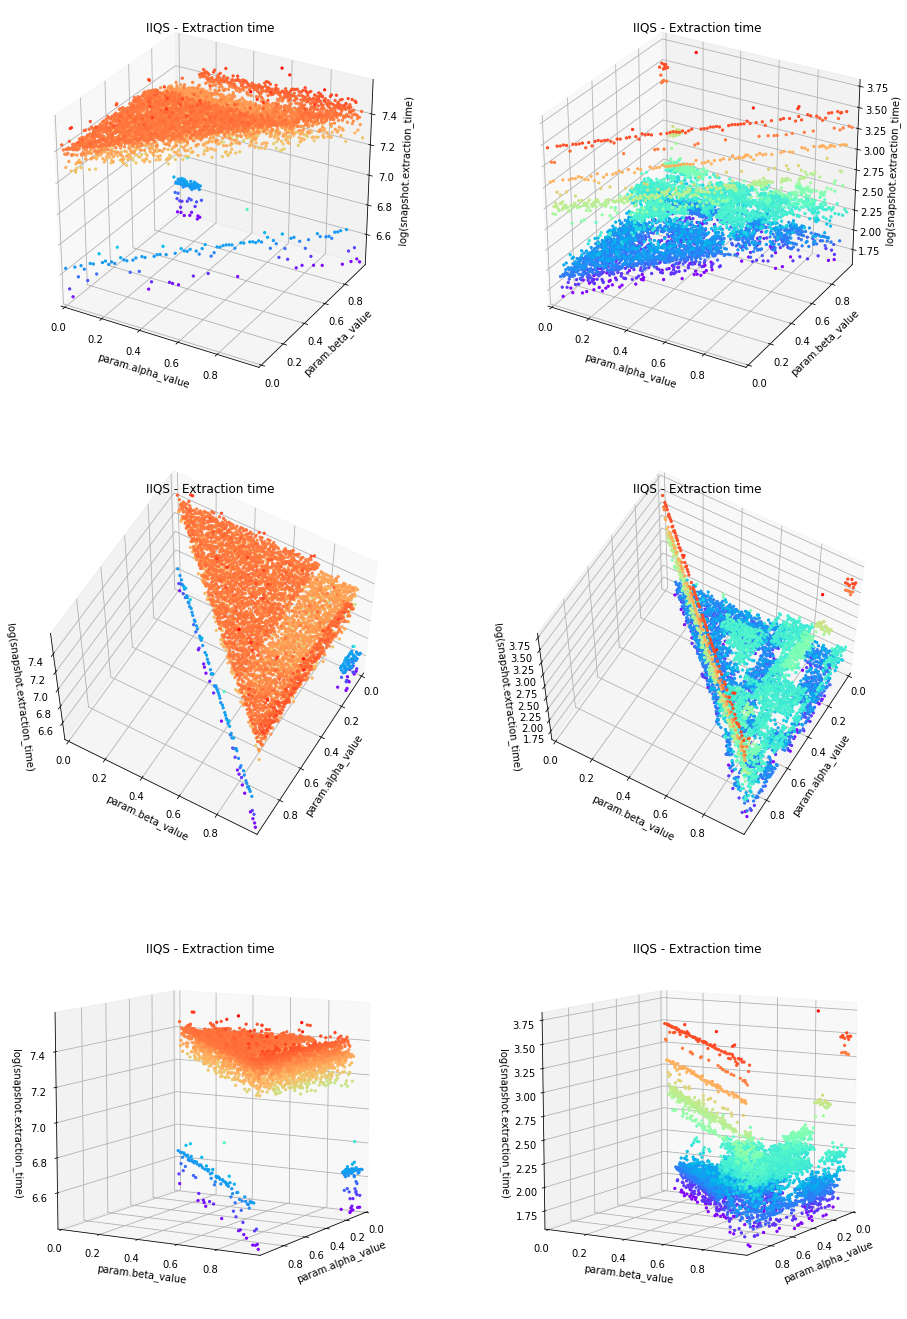

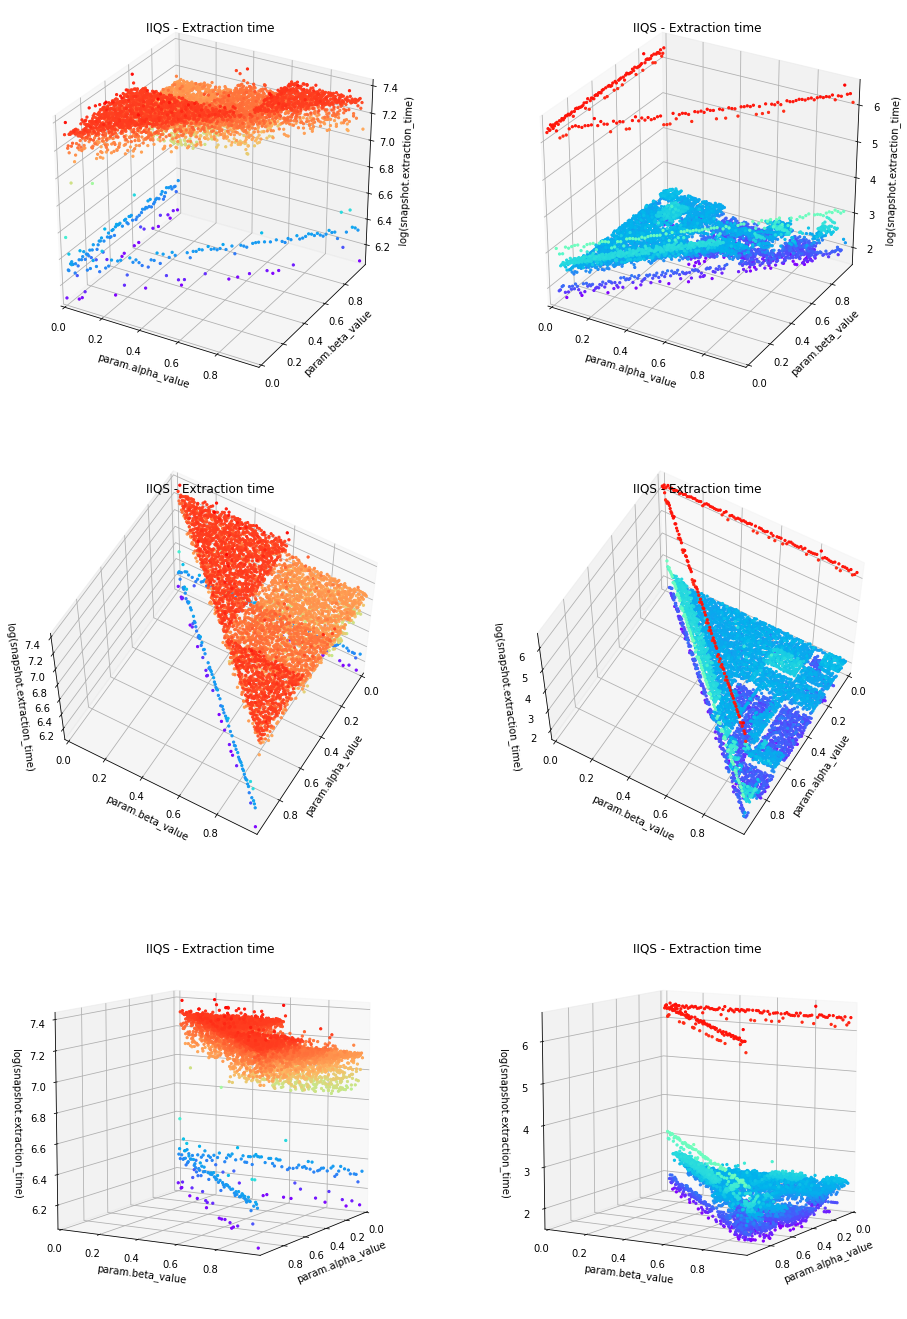

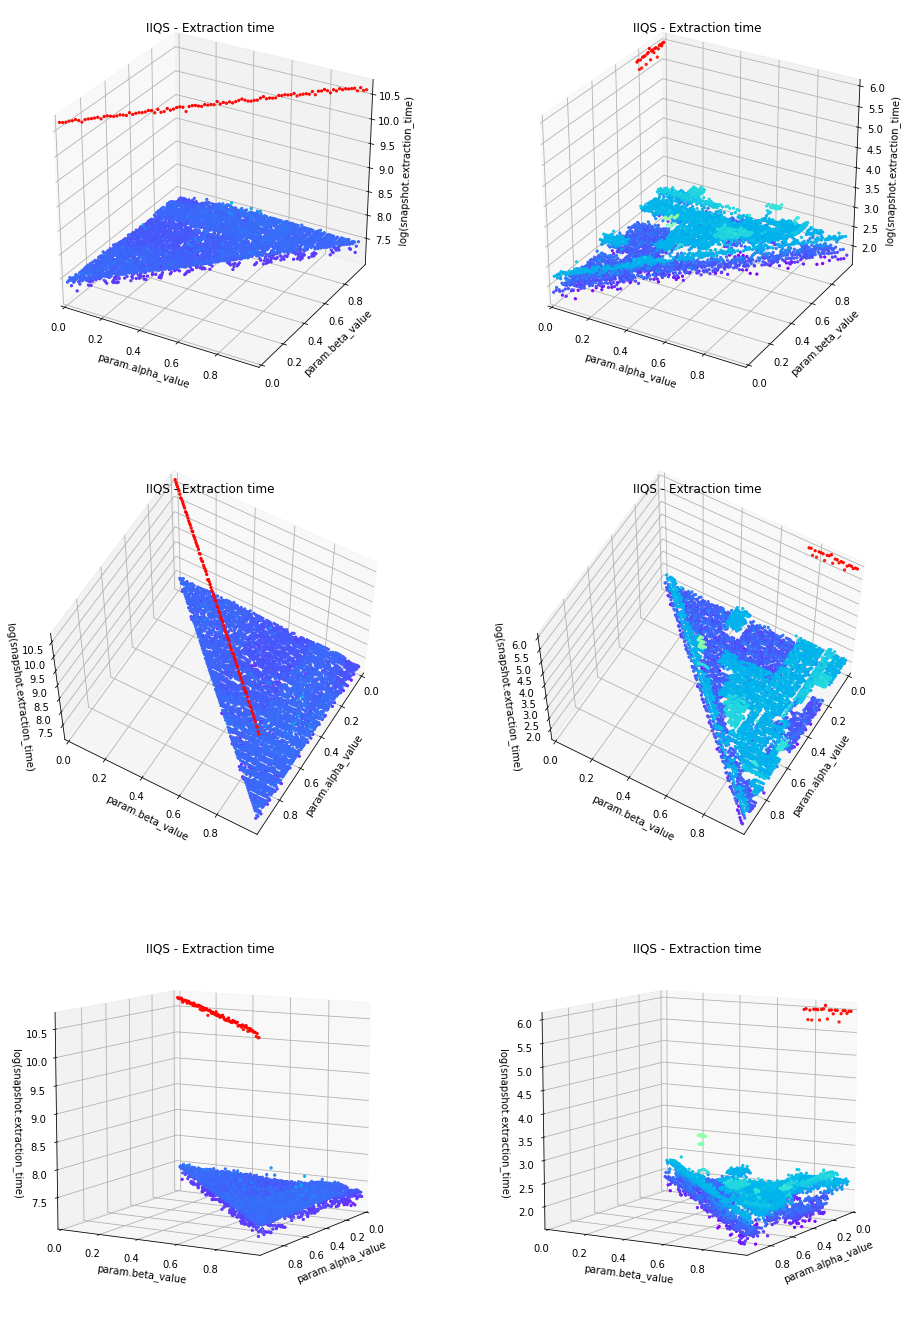

In [42]:
#"bins/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"
N = 5
n = 10**N
extractions = 10**N
pivot_bias = 0.0
redundant_bias = 0.5
## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
alpha_values = list(numpy.arange(0.0,0.4,0.1))
beta_values = list(numpy.arange(0.7,1.0,0.1))
combinations = []
for alpha in alpha_values:
    for beta in beta_values:
        if(alpha < beta):
            combinations.append((np.round(alpha,2), np.round(beta,2),))
R = 0
len(combinations)

In [43]:
filename = 'random/N_6.fold_1.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_rand_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_rand_d = result_df_alphabeta_rand_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_rand_d["param.alpha_value"] = result_df_alphabeta_rand_d["alpha_value"]

result_df_alphabeta_rand_d["variant"]  = "a" + result_df_alphabeta_rand_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_rand_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_rand_d, "04_alphabeta_detail_random.png", prepend="RANDOM - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


In [44]:
filename = 'sorted_increasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_asc_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_asc_d = result_df_alphabeta_asc_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_asc_d["param.alpha_value"] = result_df_alphabeta_asc_d["alpha_value"]

result_df_alphabeta_asc_d["variant"]  = "a" + result_df_alphabeta_asc_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_asc_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_asc_d, "04_alphabeta_detail_increasing.png", prepend="ASC - ", hue="variant")

In [45]:
filename = 'sorted_decreasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_desc_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_desc_d = result_df_alphabeta_desc_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_desc_d["param.alpha_value"] = result_df_alphabeta_desc_d["alpha_value"]

result_df_alphabeta_desc_d["variant"]  = "a" + result_df_alphabeta_desc_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_desc_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_desc_d, "04_alphabeta_detail_decreasing.png", prepend="DESC - ", hue="variant")

/home/kuky_nekoi/.anaconda3/envs/magicode/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


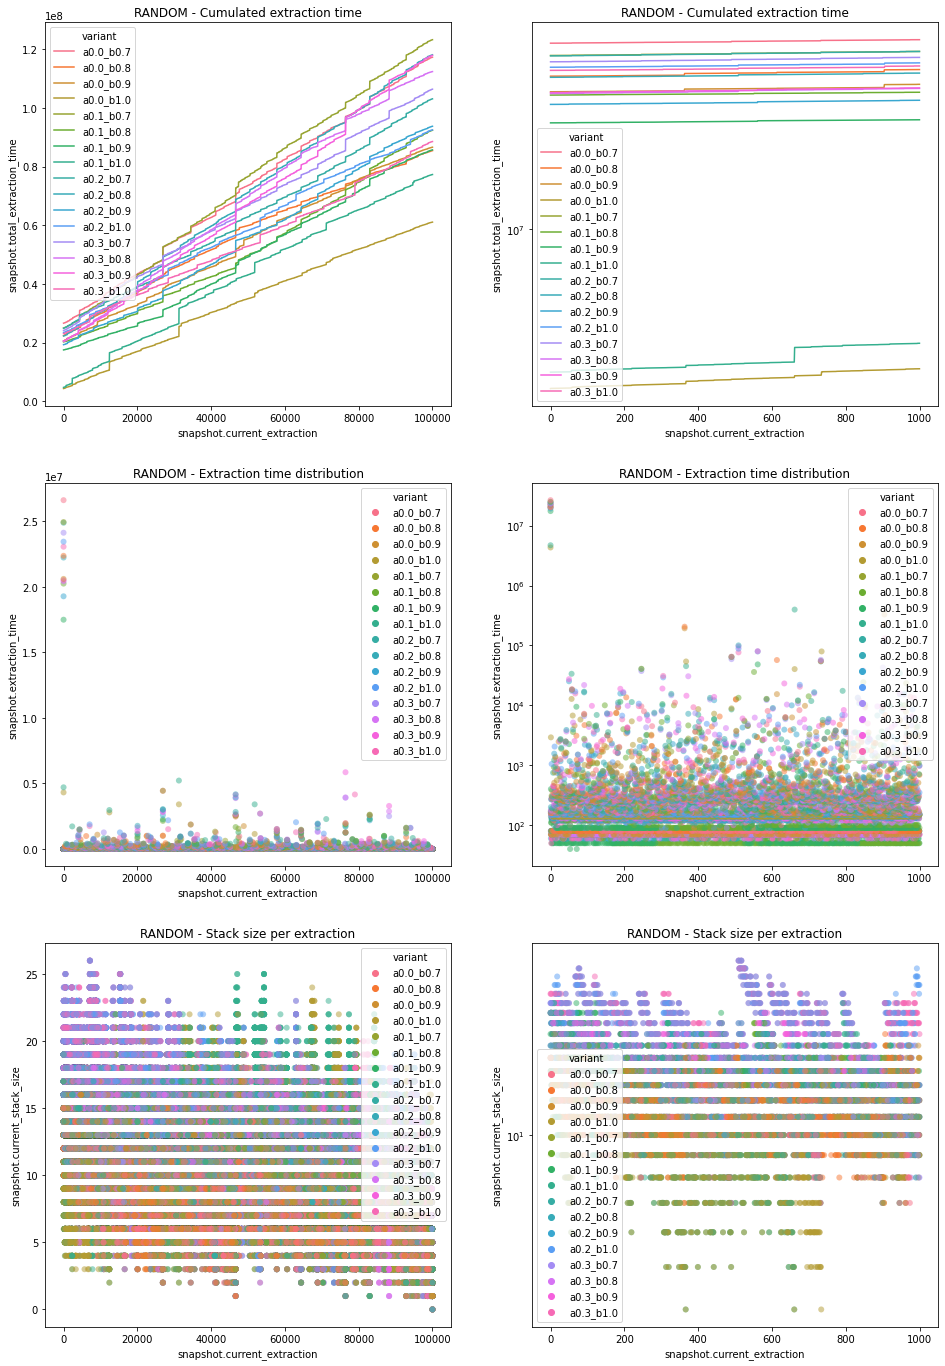

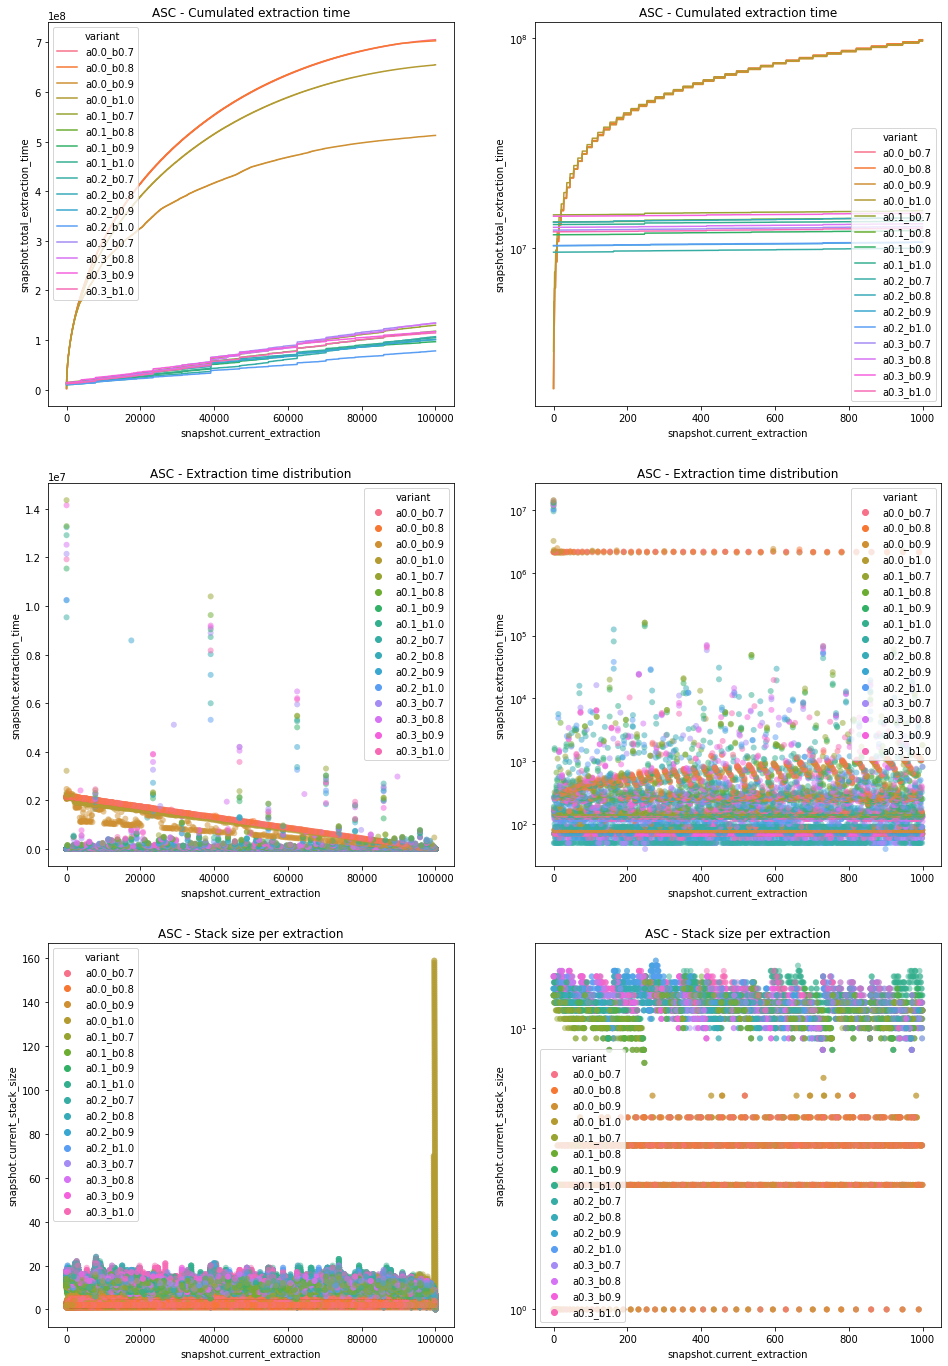

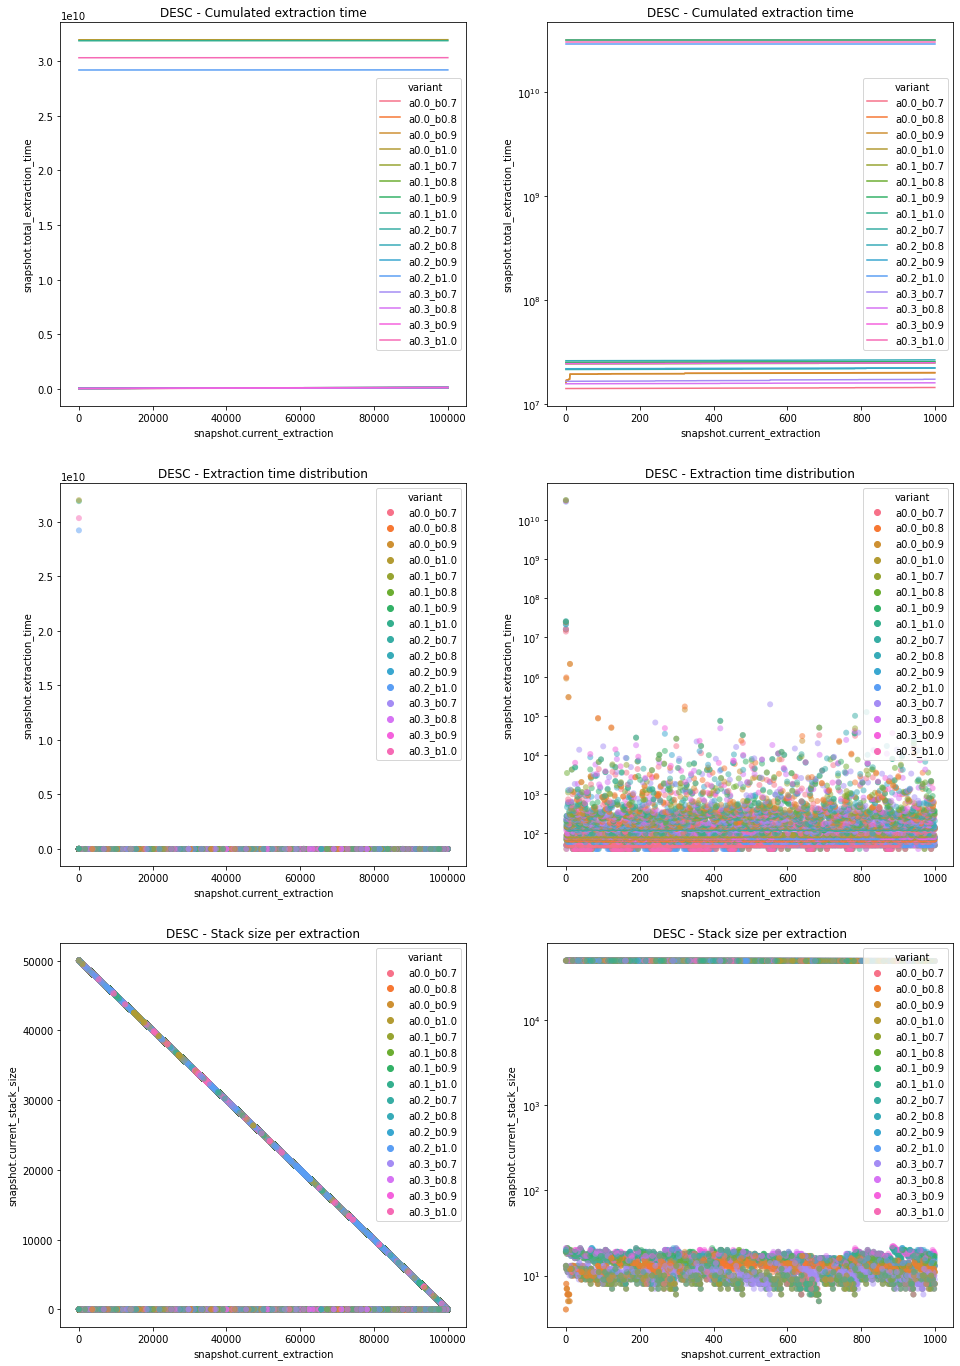

In [46]:
#uwu

In [47]:
#"bins/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"
N = 5
n = 10**N
extractions = 10**N
pivot_bias = 0.0
redundant_bias = 0.5
## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
alpha_values = list(numpy.arange(0.4,0.8,.05))
beta_values = list(numpy.arange(0.4,0.75,.05))
combinations = []
for alpha in alpha_values:
    for beta in beta_values:
        if(alpha < beta):
            combinations.append((np.round(alpha,2), np.round(beta,2),))
R = 0
display(len(combinations))
combinations


21

[(0.4, 0.45),
 (0.4, 0.5),
 (0.4, 0.55),
 (0.4, 0.6),
 (0.4, 0.65),
 (0.4, 0.7),
 (0.45, 0.5),
 (0.45, 0.55),
 (0.45, 0.6),
 (0.45, 0.65),
 (0.45, 0.7),
 (0.5, 0.55),
 (0.5, 0.6),
 (0.5, 0.65),
 (0.5, 0.7),
 (0.55, 0.6),
 (0.55, 0.65),
 (0.55, 0.7),
 (0.6, 0.65),
 (0.6, 0.7),
 (0.65, 0.7)]

In [48]:
filename = 'random/N_6.fold_1.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_rand_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_rand_d = result_df_alphabeta_rand_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_rand_d["param.alpha_value"] = result_df_alphabeta_rand_d["alpha_value"]

result_df_alphabeta_rand_d["variant"]  = "a" + result_df_alphabeta_rand_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_rand_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_rand_d, "04_alphabeta_detail_random_inner.png", prepend="RANDOM - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


In [49]:
filename = 'sorted_increasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_asc_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_asc_d = result_df_alphabeta_asc_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_asc_d["param.alpha_value"] = result_df_alphabeta_asc_d["alpha_value"]

result_df_alphabeta_asc_d["variant"]  = "a" + result_df_alphabeta_asc_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_asc_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_asc_d, "04_alphabeta_detail_increasing_inner.png", prepend="ASC - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


In [23]:
filename = 'sorted_decreasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_desc_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_desc_d = result_df_alphabeta_desc_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_desc_d["param.alpha_value"] = result_df_alphabeta_desc_d["alpha_value"]

result_df_alphabeta_desc_d["variant"]  = "a" + result_df_alphabeta_desc_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_desc_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_desc_d, "04_alphabeta_detail_decreasing_inner.png", prepend="DESC - ", hue="variant")

<ipython-input-6-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


20

[(0.0, 0.7),
 (0.02, 0.7),
 (0.03, 0.7),
 (0.04, 0.7),
 (0.06, 0.7),
 (0.08, 0.7),
 (0.09, 0.7),
 (0.1, 0.7),
 (0.12, 0.7),
 (0.14, 0.7),
 (0.15, 0.7),
 (0.16, 0.7),
 (0.18, 0.7),
 (0.2, 0.7),
 (0.21, 0.7),
 (0.22, 0.7),
 (0.24, 0.7),
 (0.26, 0.7),
 (0.27, 0.7),
 (0.28, 0.7)]

/home/kuky_nekoi/.anaconda3/envs/magicode/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


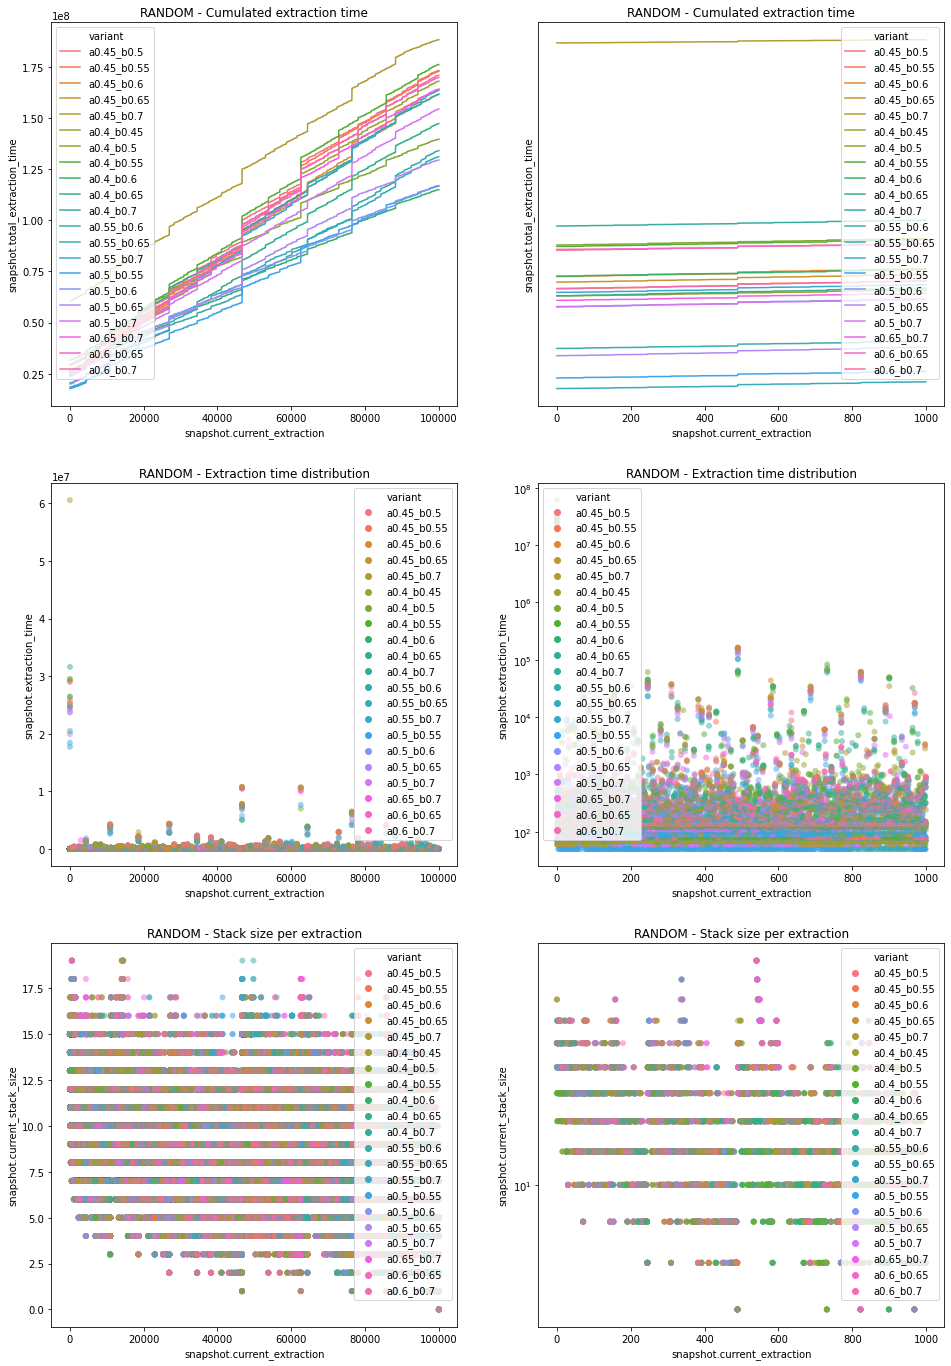

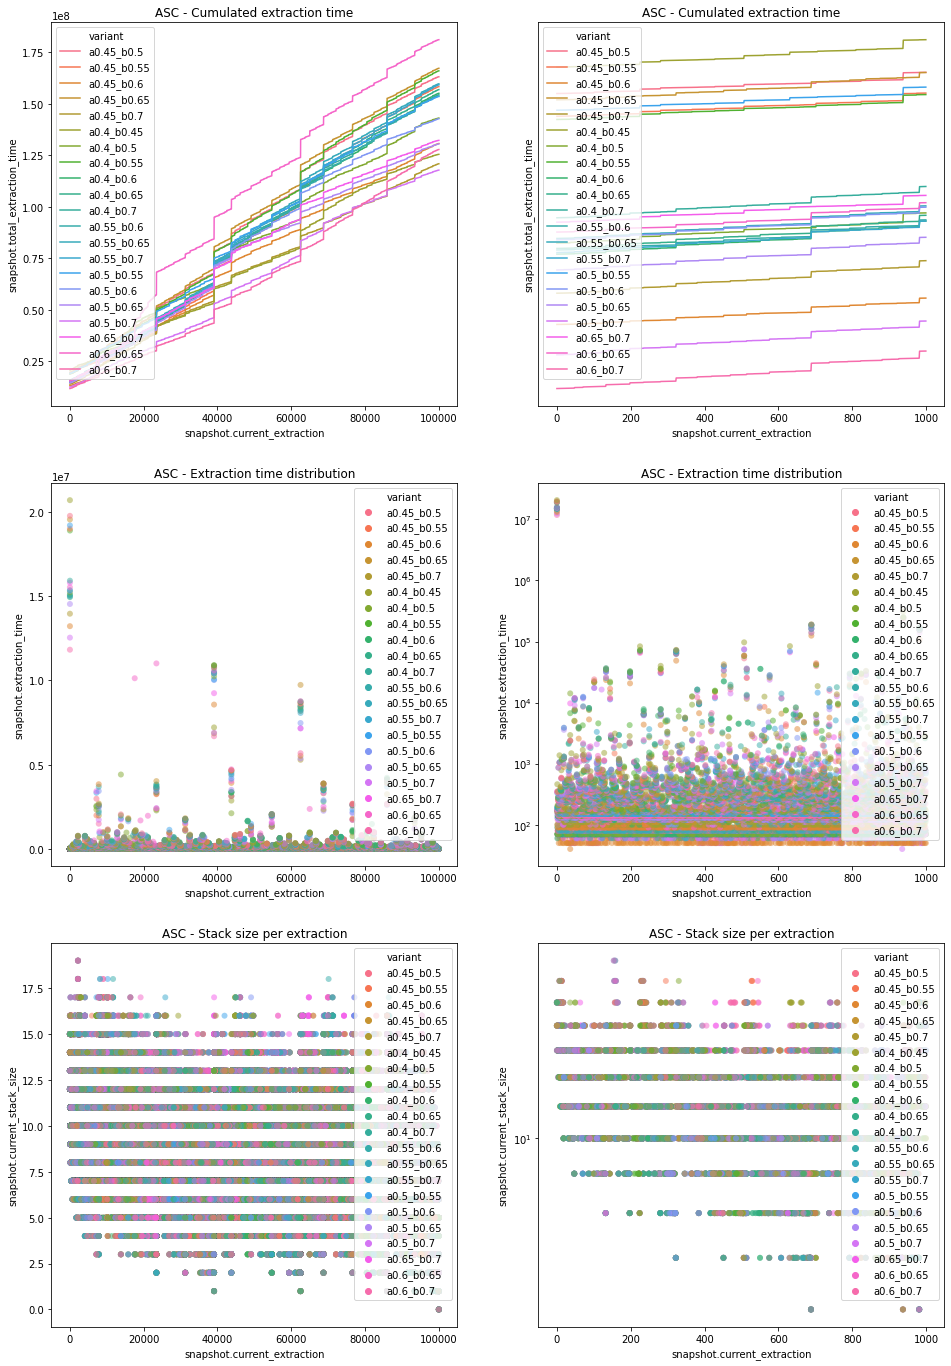

In [50]:
#"bins/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"
N = 5
n = 10**N
extractions = 10**N
pivot_bias = 0.0
redundant_bias = 0.5
## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
alpha_values = list(numpy.arange(0.0,0.3,.015))
beta_values = [0.7]
combinations = []
for alpha in alpha_values:
    for beta in beta_values:
        if(alpha < beta):
            combinations.append((np.round(alpha,2), np.round(beta,2),))
R = 0
display(len(combinations))
combinations


In [51]:
filename = 'random/N_6.fold_1.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_rand_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_rand_d = result_df_alphabeta_rand_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_rand_d["param.alpha_value"] = result_df_alphabeta_rand_d["alpha_value"]

result_df_alphabeta_rand_d["variant"]  = "a" + result_df_alphabeta_rand_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_rand_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_rand_d, "04_alphabeta_detail_random_left.png", prepend="RANDOM - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


In [52]:
filename = 'sorted_increasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_asc_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_asc_d = result_df_alphabeta_asc_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_asc_d["param.alpha_value"] = result_df_alphabeta_asc_d["alpha_value"]

result_df_alphabeta_asc_d["variant"]  = "a" + result_df_alphabeta_asc_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_asc_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_asc_d, "04_alphabeta_detail_increasing_left.png", prepend="ASC - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


In [53]:
filename = 'sorted_decreasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_desc_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_desc_d = result_df_alphabeta_desc_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_desc_d["param.alpha_value"] = result_df_alphabeta_desc_d["alpha_value"]

result_df_alphabeta_desc_d["variant"]  = "a" + result_df_alphabeta_desc_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_desc_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_desc_d, "04_alphabeta_detail_decreasing_left.png", prepend="DESC - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


In [21]:
#"bins/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"
N = 5
n = 10**N
extractions = 10**N
pivot_bias = 0.0
redundant_bias = 0.5
## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
alpha_values = [0.3]
beta_values = list(numpy.arange(0.7,1.0,.015))
combinations = []
for alpha in alpha_values:
    for beta in beta_values:
        if(alpha < beta):
            combinations.append((np.round(alpha,2), np.round(beta,2),))
R = 0
display(len(combinations))
combinations


21

[(0.3, 0.7),
 (0.3, 0.72),
 (0.3, 0.73),
 (0.3, 0.74),
 (0.3, 0.76),
 (0.3, 0.78),
 (0.3, 0.79),
 (0.3, 0.8),
 (0.3, 0.82),
 (0.3, 0.84),
 (0.3, 0.85),
 (0.3, 0.87),
 (0.3, 0.88),
 (0.3, 0.9),
 (0.3, 0.91),
 (0.3, 0.93),
 (0.3, 0.94),
 (0.3, 0.96),
 (0.3, 0.97),
 (0.3, 0.99),
 (0.3, 1.0)]

In [55]:
filename = 'random/N_6.fold_1.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_rand_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_rand_d = result_df_alphabeta_rand_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_rand_d["param.alpha_value"] = result_df_alphabeta_rand_d["alpha_value"]

result_df_alphabeta_rand_d["variant"]  = "a" + result_df_alphabeta_rand_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_rand_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_rand_d, "04_alphabeta_detail_random_right.png", prepend="RANDOM - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


In [56]:
filename = 'sorted_increasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_asc_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_asc_d = result_df_alphabeta_asc_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_asc_d["param.alpha_value"] = result_df_alphabeta_asc_d["alpha_value"]

result_df_alphabeta_asc_d["variant"]  = "a" + result_df_alphabeta_asc_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_asc_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_asc_d, "04_alphabeta_detail_increasing_right.png", prepend="ASC - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


In [57]:
filename = 'sorted_decreasing/N_6.ascii'
iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], filename, extractions=extractions) for c in combinations )

result_df_alphabeta_desc_d = log_column('snapshot.extraction_time')(pandas.concat(iiqs_results))
result_df_alphabeta_desc_d = result_df_alphabeta_desc_d.sort_values(["snapshot.extraction_time"])
result_df_alphabeta_desc_d["param.alpha_value"] = result_df_alphabeta_desc_d["alpha_value"]

result_df_alphabeta_desc_d["variant"]  = "a" + result_df_alphabeta_desc_d["param.alpha_value"].astype(str) + "_b" + result_df_alphabeta_desc_d["param.beta_value"].astype(str)

plot_base_benchmark(result_df_alphabeta_desc_d, "04_alphabeta_detail_decreasing_right.png", prepend="DESC - ", hue="variant")

<ipython-input-28-5dfc72e2a933>:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(OUTPUT_IMAGE_PATH + output_file, bbox_inches='tight')


/home/kuky_nekoi/.anaconda3/envs/magicode/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


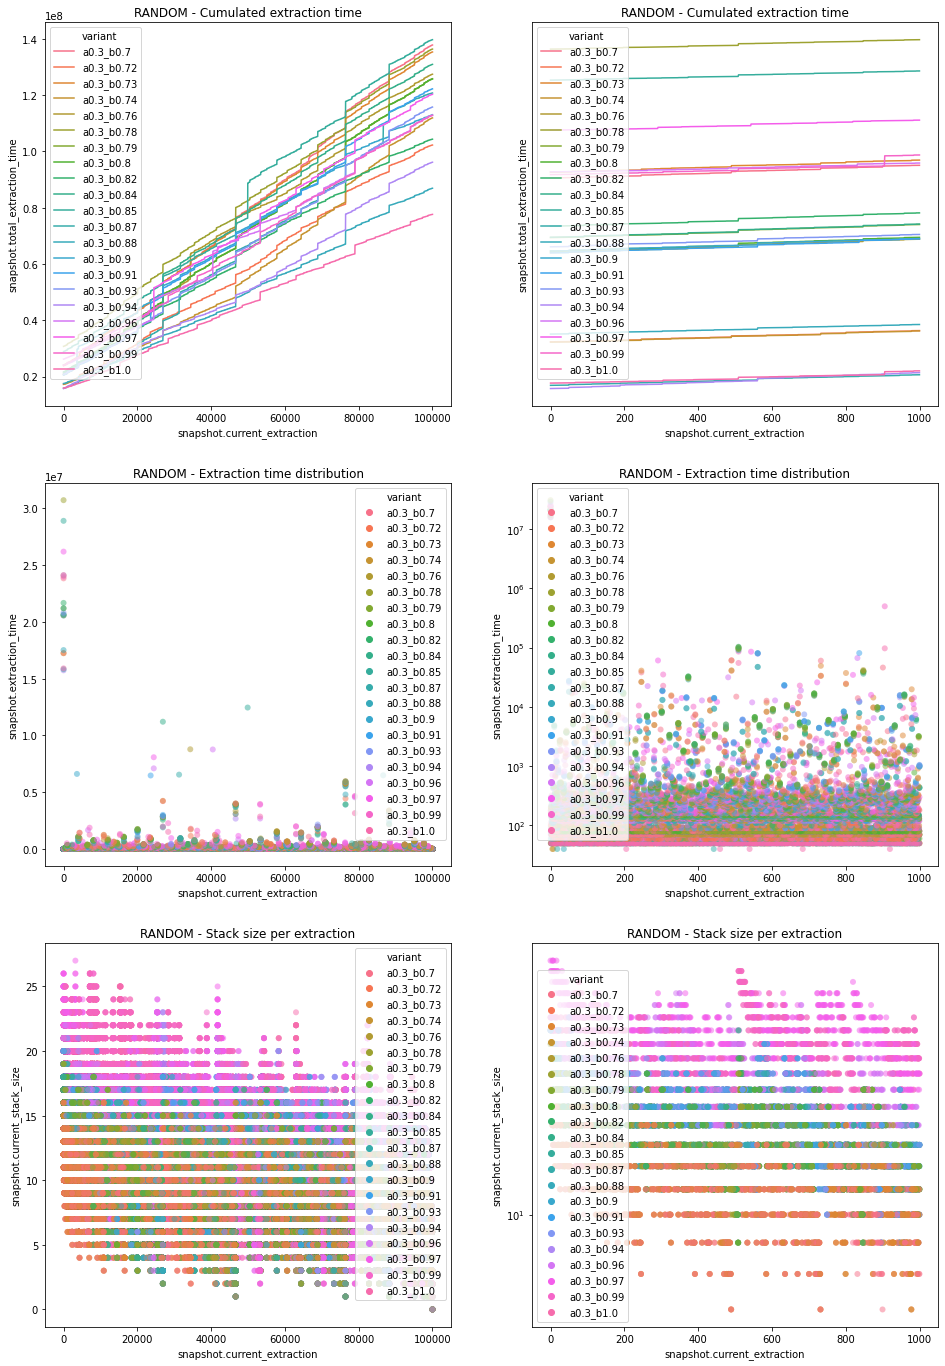

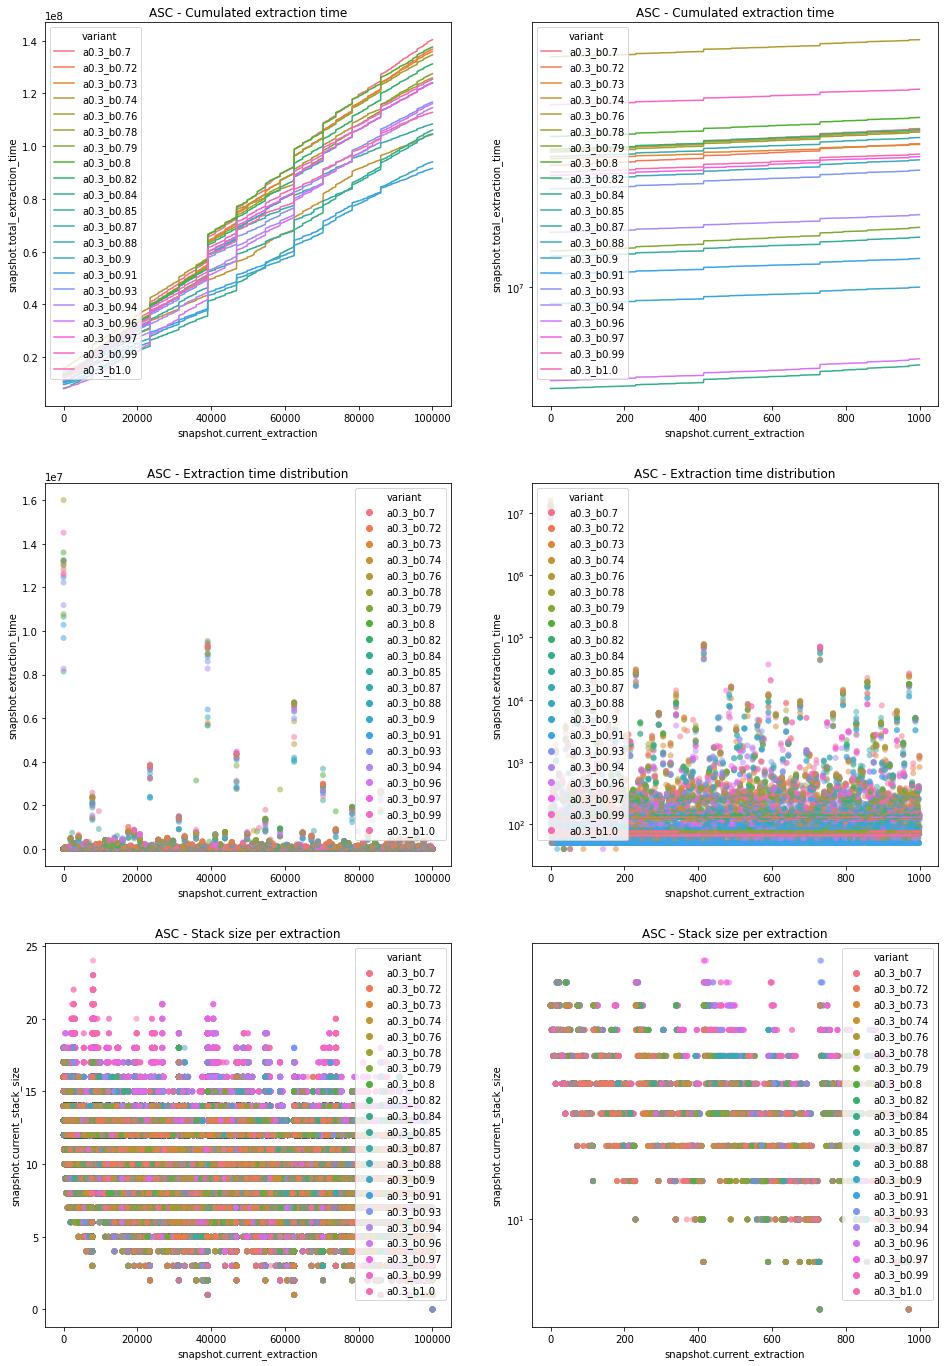

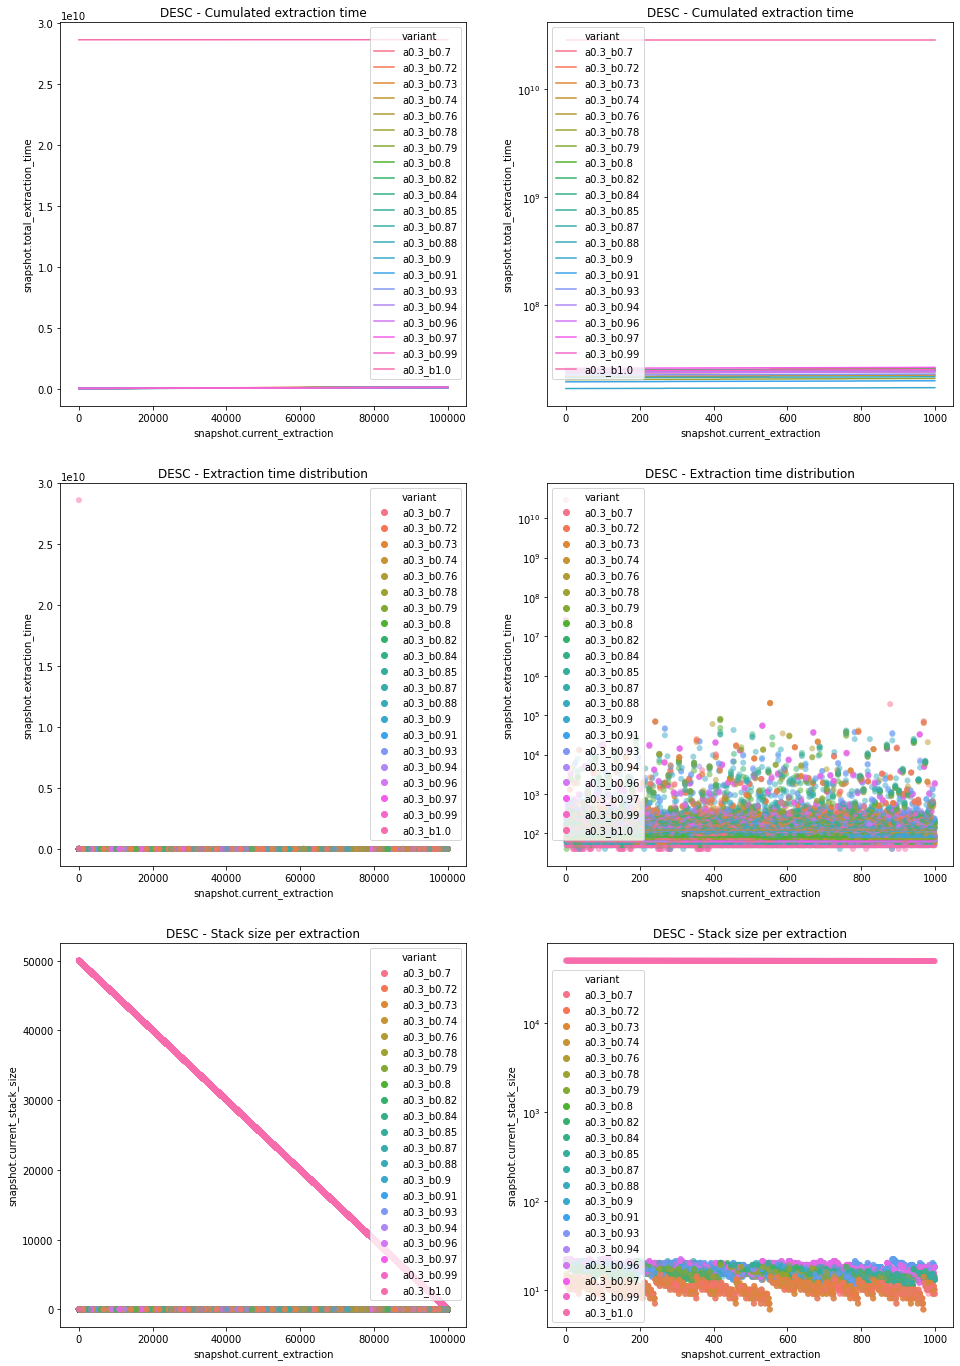

In [58]:
#

In [61]:
def preserve_last(dataframe: pandas.DataFrame, sortby="snapshot.current_extraction") -> pandas.DataFrame:
    #max_index = result_df_alphabeta_rand_d["snapshot.current_extraction"]==max_extract_val
    ## slow as fuck
    #dataframe_ = dataframe.sort_values(["snapshot.current_extraction"])
    #dataframe_last_ = dataframe_.tail(1) 
    dataframe_desc_ = dataframe.describe().to_json()
    idx_ = dataframe["snapshot.current_extraction"].idxmax()
    dataframe_last_ = dataframe.loc[idx_]
    dataframe_last_["experiment.describe"] = dataframe_desc_
    return dataframe_last_.copy(deep=True)

In [62]:
#"bins/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"
N = 4
n = 10**N
extractions=n
pivot_bias = 0.0
redundant_bias = 1
## Iterate for all classes available with 10% increments
increment_10p = int(n/100)
fold = 1
alpha_values = list(numpy.arange(0,1,0.01))
beta_values = list(numpy.arange(0,1,0.01))
combinations = []
for alpha in alpha_values:
    for beta in beta_values:
        if(alpha <= beta):
            combinations.append((alpha, beta,))
R = 0

In [65]:
#filename = 'random/N_6.fold_1.ascii'
C = 1

filename = "one_bin_noise/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"

iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], 
                                                           filename, 
                                                           extractions=5) for c in combinations )

dataframes = []
dataframes.extend(iiqs_results)
        

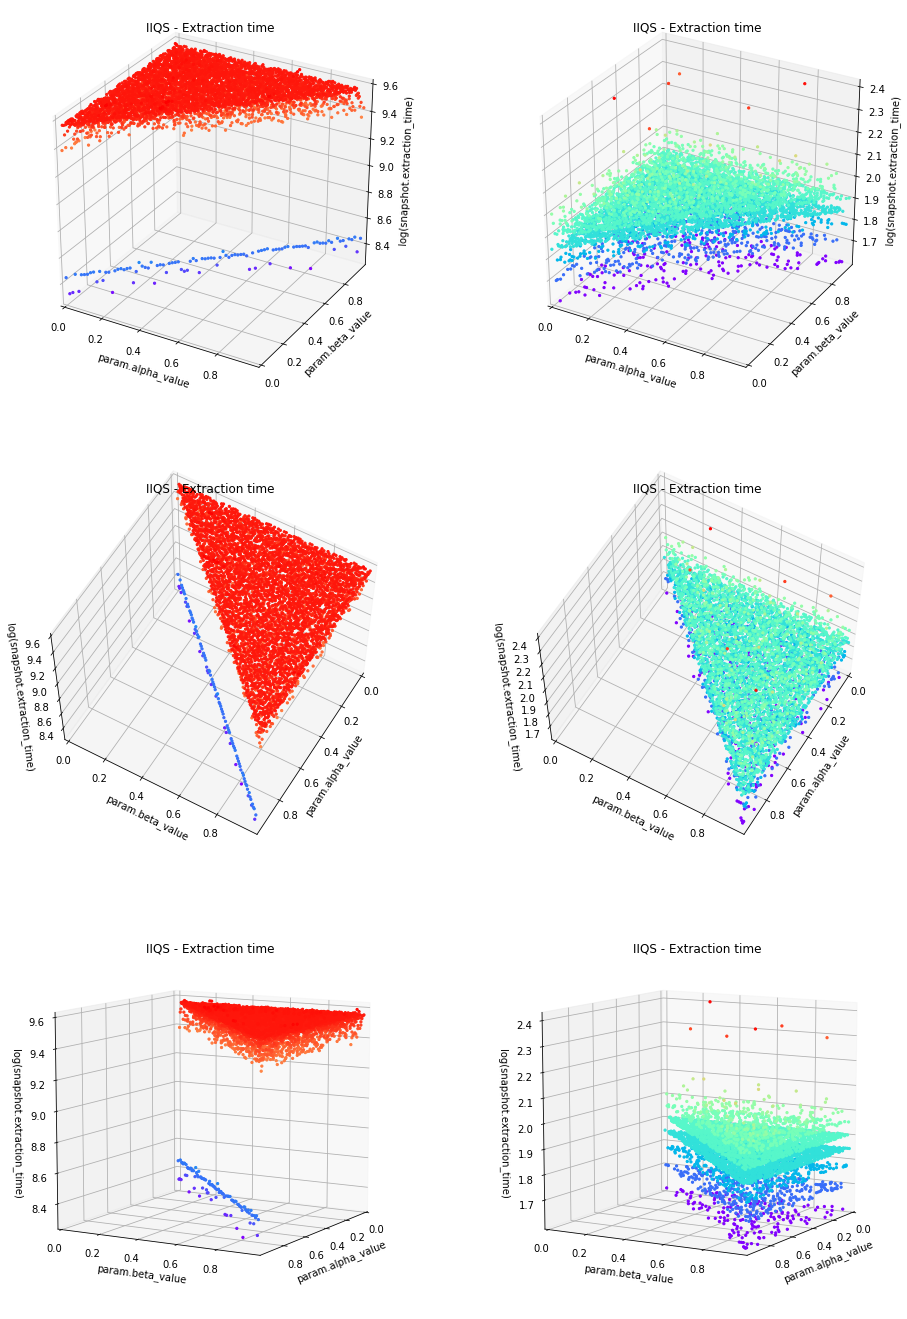

In [66]:
result_df_alphabeta = log_column('snapshot.extraction_time')(pandas.concat(dataframes))
result_df_alphabeta = result_df_alphabeta.sort_values(["snapshot.extraction_time"])
result_df_alphabeta["param.alpha_value"] = result_df_alphabeta["alpha_value"]

plot_base_benchmark_3d(x='param.alpha_value',y='param.beta_value',z='log(snapshot.extraction_time)',
                       data=result_df_alphabeta[result_df_alphabeta["snapshot.current_extraction"] < 2], 
                       filters=[], 
                       title="Extraction time", file="04_alpabeta_singleclass.png", s=5)

In [155]:
## idk why
#filename = 'random/N_6.fold_1.ascii'
import json

In [67]:
C = 1

filename = "one_bin_noise/N_" + str(N) + "_R_" + str(R) + "_C_" + str(C) + ".fold_" + str(fold) + ".ascii"

iiqs_results = Parallel(n_jobs=10)( delayed(parallel_iiqs)(c[0], c[1], 
                                                           filename, 
                                                           extractions=extractions, 
                                                           postprocess=preserve_last) for c in combinations )

dataframes = []
dataframes.extend(iiqs_results)
        

In [93]:
result_df_alphabeta = pandas.concat(dataframes)
result_df_alphabeta = pandas.DataFrame.from_records(dataframes)
result_df_alphabeta = result_df_alphabeta.sort_values("snapshot.current_stack_size")
result_df_alphabeta["param.alpha_value"] = result_df_alphabeta["alpha_value"]

In [158]:
def append_describe(row) -> pandas.Series:
    x = json.loads(row["experiment.describe"])
    for k_1, v_1 in x.items():
        for k_2, v_2 in v_1.items():
            column = k_1 + ".describe." + k_2
            value = v_2
            row[column] = value
    return row

In [165]:
def parallel_job_apply(dataframe,  apply_function) -> pandas.DataFrame:
    return dataframe.apply(apply_function, axis=1)

def parallel_job_split_apply(dataframe, apply_function, parts=12):
    splitted_dataframe = numpy.array_split(dataframe, parts)
    fragments = Parallel(n_jobs=12)(delayed(parallel_job_apply)(part, apply_function) for part in splitted_dataframe )
    return pandas.concat(fragments)

In [ ]:
result_df_alphabeta_proc = parallel_job_split_apply(result_df_alphabeta, append_describe, 12)

In [ ]:
[print(x) for x in result_df_alphabeta_proc.columns]

In [177]:
result_df_alphabeta_proc

index  param.log_pivot_time  param.log_iteration_time  \
0      9999                     0                         0   
3369   9999                     0                         0   
3368   9999                     0                         0   
3367   9999                     0                         0   
3366   9999                     0                         0   
...     ...                   ...                       ...   
1681   9999                     0                         0   
1680   9999                     0                         0   
1679   9999                     0                         0   
1686   9999                     0                         0   
5049   9999                     0                         0   

      param.log_extraction_time  param.log_swaps  param.use_bfprt  \
0                             1                0                1   
3369                          1                0                1   
3368                          1                0                1   
3367                          1                0                1   
3366                          1                0                1   
...                         ...              ...              ...   
1681                          1                0                1   
1680                          1                0                1   
1679                          1                0                1   
1686                          1                0                1   
5049                          1                0                1   

      param.use_iiqs  param.use_dutch_flag  param.use_random_pivot  \
0                  1                     1                       0   
3369               1                     1                       0   
3368               1                     1                       0   
3367               1                     1                       0   
3366               1                     1                       0   
...              ...                   ...                     ...   
1681               1                     1                       0   
1680               1                     1                       0   
1679               1                     1                       0   
1686               1                     1                       0   
5049               1                     1                       0   

      param.enable_reuse  alpha_value  param.beta_value  param.pivot_bias  \
0                      0         0.00              0.00                 0   
3369                   0         0.42              0.72                 0   
3368                   0         0.42              0.71                 0   
3367                   0         0.42              0.70                 0   
3366                   0         0.42              0.69                 0   
...                  ...          ...               ...               ...   
1681                   0         0.18              0.52                 0   
1680                   0         0.18              0.51                 0   
1679                   0         0.18              0.50                 0   
1686                   0         0.18              0.57                 0   
5049                   0         0.99              0.99                 0   

      param.redundant_bias  random_seed_value  input_size  param.extractions  \
0                        1                 42       10000              10000   
3369                     1                 42       10000              10000   
3368                     1                 42       10000              10000   
3367                     1                 42       10000              10000   
3366                     1                 42       10000              10000   
...                    ...                ...         ...                ...   
1681                     1                 42       10000              10000   
1680          

<ipython-input-19-cf1960e42f96>:51: UserWarning: Attempting to set identical bottom == top == 9999.0 results in singular transformations; automatically expanding.
  ax.set_zlim(min(_z), max(_z))


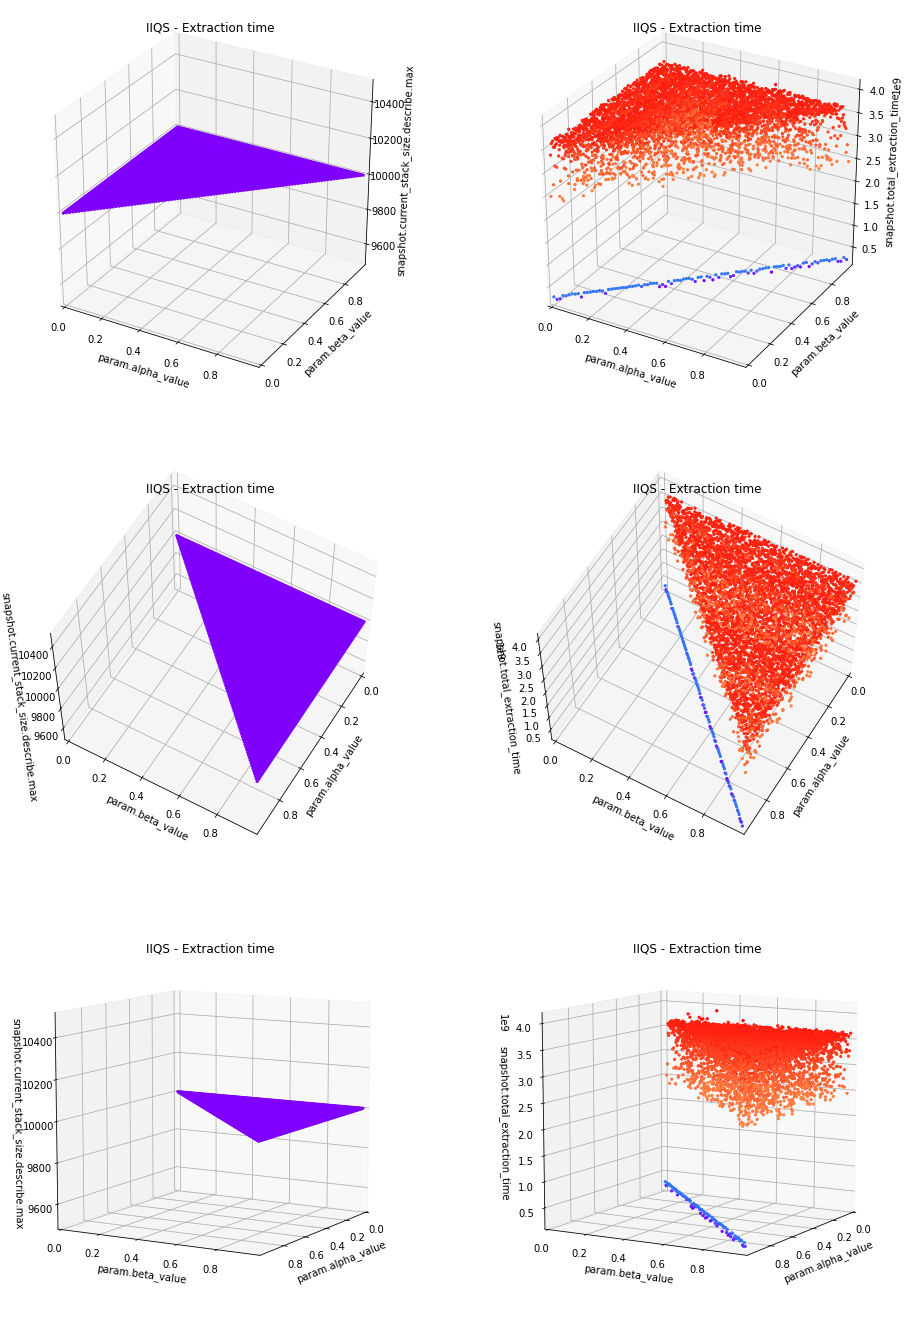

In [173]:
plot_stack_benchmark_3d(x='param.alpha_value',y='param.beta_value',z='snapshot.current_stack_size.describe.max',
                       data=result_df_alphabeta_proc, 
                        filters=[], 
                       title="Extraction time", 
                       file="04_alphabeta_singleclass_stack.png", s=5,
                      z2='snapshot.total_extraction_time')